In [1]:
!pip install deltalake
DELTA_LAKE_TABLE = "/mnt/deltalake/loans.delta"

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
import configparser
from deltalake import DeltaTable

config = configparser.ConfigParser()
config.read("/mnt/deltalake/deltalake.ini")

if config["DEFAULT"]["TABLE_SOURCE"] == "hostpath":
    prefix = config["DEFAULT"]["TABLE_PATH"]
    user_homedir = os.getenv("DKUBE_USER_STORE")
    path = f'{user_homedir}/{prefix}'
    version = int(config["DEFAULT"]["TABLE_VERSION"])

    dt = DeltaTable(path)
elif config["DEFAULT"]["TABLE_SOURCE"] == "s3":
    prefix = config["DEFAULT"]["TABLE_PATH"]
    region = config["DEFAULT"]["AWS_REGION"]
    access_key = config["DEFAULT"].get("AWS_ACCESS_KEY_ID", "")
    access_secret = config["DEFAULT"].get("AWS_SECRET_ACCESS_KEY", "")
    version = int(config["DEFAULT"]["TABLE_VERSION"])

    if access_secret != "":
        storage_options = {"AWS_ACCESS_KEY_ID": access_key, "AWS_SECRET_ACCESS_KEY": access_secret, "AWS_REGION": region}
        dt = DeltaTable(f's3://{prefix}', storage_options=storage_options)
    else:
        #May be the role or ~/.aws/credentials is set
        storage_options = {"AWS_REGION": region}
        dt = DeltaTable(f's3://{prefix}', storage_options=storage_options)

In [3]:
dt.load_version(version)
print("Loaded verion => ", dt.version())

Loaded verion =>  2


In [4]:
df_clean = dt.to_pandas()
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()

df_clean['term'] = label.fit_transform(df_clean['term'])
df_clean['grade'] = label.fit_transform(df_clean['grade'])
# df_clean['emp_length'] = label.fit_transform(df_clean['emp_length'])
df_clean['home_ownership'] = label.fit_transform(df_clean['home_ownership'])
df_clean['verification_status'] = label.fit_transform(df_clean['verification_status'])
df_clean['pymnt_plan'] = label.fit_transform(df_clean['pymnt_plan'])
df_clean['purpose'] = label.fit_transform(df_clean['purpose'])
df_clean['initial_list_status'] = label.fit_transform(df_clean['initial_list_status'])
df_clean['application_type'] = label.fit_transform(df_clean['application_type'])
df_clean['int_rate'] = label.fit_transform(df_clean['int_rate'])
df_clean['total_pymnt'] = label.fit_transform(df_clean['total_pymnt'])
df_clean['total_pymnt_inv'] = label.fit_transform(df_clean['total_pymnt_inv'])
df_clean['total_rec_prncp'] = label.fit_transform(df_clean['total_rec_prncp'])
df_clean['recoveries']= label.fit_transform(df_clean['recoveries'])
df_clean['collection_recovery_fee']= label.fit_transform(df_clean['collection_recovery_fee'])
df_clean['last_pymnt_amnt']= label.fit_transform(df_clean['last_pymnt_amnt'])

df_clean.head()

,loan_status,term,grade,home_ownership,verification_status,pymnt_plan,purpose,initial_list_status,application_type,total_pymnt,total_pymnt_inv,total_rec_prncp,recoveries,collection_recovery_fee,last_pymnt_amnt,int_rate,__index_level_0__
0,1,0,1,4,2,0,1,0,0,10282,11134,4190,0,0,5710,17,0
1,0,1,2,4,1,0,0,0,0,552,1003,461,953,159,3923,158,1
2,1,0,2,4,0,0,11,0,0,3891,4714,2527,0,0,16248,175,2
3,1,0,2,4,1,0,9,0,0,22667,23178,5573,0,0,11639,99,3
4,1,0,0,4,1,0,13,0,0,9627,10621,4190,0,0,5259,337,5


In [5]:
x = df_clean.drop(['loan_status'], axis=1)
y = df_clean['loan_status']

x.head()

,term,grade,home_ownership,verification_status,pymnt_plan,purpose,initial_list_status,application_type,total_pymnt,total_pymnt_inv,total_rec_prncp,recoveries,collection_recovery_fee,last_pymnt_amnt,int_rate,__index_level_0__
0,0,1,4,2,0,1,0,0,10282,11134,4190,0,0,5710,17,0
1,1,2,4,1,0,0,0,0,552,1003,461,953,159,3923,158,1
2,0,2,4,0,0,11,0,0,3891,4714,2527,0,0,16248,175,2
3,0,2,4,1,0,9,0,0,22667,23178,5573,0,0,11639,99,3
4,0,0,4,1,0,13,0,0,9627,10621,4190,0,0,5259,337,5


In [13]:
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, roc_curve

import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

import joblib
import numpy as np 
import mlflow.sklearn
import urllib3
import json
import time

urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

In [14]:
coltrans = ColumnTransformer(
    [('one_hot_encoder', OneHotEncoder(categories='auto'), [0,1,2,3,4,5,6,7,8])],        
    remainder = 'passthrough'                               
)
xtr, xts, ytr, yts = train_test_split(
    x,
    y,
    test_size = .2,
)

start = time.time()

The training took 12.02 seconds.
Accuracy => 98.72 %


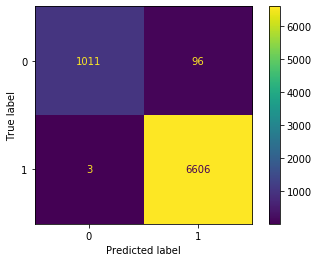

              precision    recall  f1-score   support

    Bad Loan       1.00      0.91      0.95      1107
   Good Loan       0.99      1.00      0.99      6609

    accuracy                           0.99      7716
   macro avg       0.99      0.96      0.97      7716
weighted avg       0.99      0.99      0.99      7716



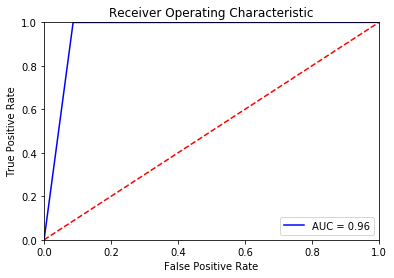

<Figure size 432x288 with 0 Axes>

In [15]:
with mlflow.start_run(run_name="dl-loan") as run:
    model = RandomForestClassifier()
    model.fit(xtr, ytr)

    mlflow.sklearn.log_model(model, "badloan-classifier")

    stop = time.time()
    duration = stop-start
    print('The training took {:.2f} seconds.'.format(duration))
    print("Accuracy =>", round(model.score(xts, yts) * 100, 2), '%')

    y_pred = model.predict(xts)


    cm = confusion_matrix(yts, y_pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                   display_labels=model.classes_)
    disp.plot()
    plt.show()
    plt.savefig('cm.png')

    pd.crosstab(yts, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

    target_names = ['Bad Loan', 'Good Loan']
    class_report = classification_report(yts, model.predict(xts), target_names=target_names)
    print(class_report)


    # calculate the fpr and tpr for all thresholds of the classification
    probs = model.predict_proba(xts)
    preds = probs[:,1]

    fpr, tpr, threshold = metrics.roc_curve(yts, y_pred)
    roc_auc = metrics.auc(fpr, tpr)

    # Plotting the ROC curve
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    plt.savefig('roc.png')

    acc = accuracy_score(yts, y_pred)
    precision = precision_score(yts, y_pred)
    roc = metrics.roc_auc_score(yts, y_pred)
    # confusion matrix values
    tp = cm[0][0]
    tn = cm[1][1]
    fp = cm[0][1]
    fn = cm[1][0]        

    # get classification metrics
    class_report = classification_report(yts, y_pred, output_dict=True)
    recall_0 = class_report['0']['recall']
    f1_score_0 = class_report['0']['f1-score']
    recall_1 = class_report['1']['recall']
    f1_score_1 = class_report['1']['f1-score']

    # log metrics in mlflow
    mlflow.log_metric("accuracy_score", acc)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("true_positive", tp)
    mlflow.log_metric("true_negative", tn)
    mlflow.log_metric("false_positive", fp)
    mlflow.log_metric("false_negative", fn)
    mlflow.log_metric("recall_0", recall_0)
    mlflow.log_metric("f1_score_0", f1_score_0)
    mlflow.log_metric("recall_1", recall_1)
    mlflow.log_metric("f1_score_1", f1_score_1)
    mlflow.log_metric("roc", roc)

    mlflow.log_artifact('cm.png', "confusion-matrix")
    mlflow.log_artifact('roc.png', "roc-auc-plots")
